In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s3e20/sample_submission.csv
/kaggle/input/playground-series-s3e20/train.csv
/kaggle/input/playground-series-s3e20/test.csv


In [2]:
# 処理
# ライブラリ・データセットのインポート
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:.5f}'.format
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor # 特徴量の重要度評価で用いる

FILE_PATH = '/kaggle/input/playground-series-s3e20/'
OUTPUT_DIR = '/kaggle/working/'
train = pd.read_csv(FILE_PATH + 'train.csv')
test = pd.read_csv(FILE_PATH + 'test.csv')
target = train['emission']
target_col = 'emission'
target_name = str(train.iloc[:, [-1]].columns.tolist()) # カラム数-2の値が目的変数
df = pd.concat([train, test], axis=0)
df.reset_index(inplace=True)
# 説明変数をデータ型ごとに代入する
numerical_features = df._get_numeric_data().columns
categorical_features = df.drop(numerical_features, axis=1).columns


# 前処理
# 欠損値の補完
def missing_values(df):
    df = df.drop(['location'], axis=1).fillna(0)

    return df

# 外れ値の修正
def outlier(df):

    return df

# スケーリング
# MinMaxScaler(正規化)
def scaling_MinMaxScaler(df):
    df_scale = df[numerical_features]
    sc = MinMaxScaler()
    df[numerical_features] = pd.DataFrame(sc.fit_transform(df_scale), columns = df_scale.columns)

    return df

# 特徴量エンジニアリング
# 特徴量の作成
def create_new_features(df):
    # 緯度経度ごとの平均
    df['location'] = [str(x) + '_' + str(y) for x, y in zip(df.latitude, df.longitude)]

    # 周期ごとの平均
    df_roll_mean = df.sort_values(by=['location', 'year', 'week_no']).groupby(['location'])[df.columns[5:].tolist()].rolling(window=2).mean().reset_index()
    df_roll_mean.drop(['level_1', 'emission', 'location'], axis=1, inplace=True)
    df_roll_mean.columns = [col + '_roll_mean' for col in df_roll_mean.columns]

    df = df.sort_values(by=['location', 'year', 'week_no'], ignore_index=True).merge(df_roll_mean, how='left', left_index=True, right_index=True)

    return df

# カテゴリ変数のエンコーディング
# One-Hot Encoding
def one_hot_encoding(df, cat_cols):
    df = pd.get_dummies(df, columns=cat_cols)

    return df

# Label Encoding
def label_encoder(df):
    categorical_columns = df.select_dtypes(include=['object']).columns

    for column in categorical_columns:
        df[column] = df[column].fillna('').astype('str') # 欠損値の補完をする
        le = LabelEncoder()
        df[column] = le.fit_transform(df[column])

    return df

# 特徴量の選択
# 特徴量の重要度評価
def feature_importance_evaluation(df):
    # 訓練データをX(説明変数)とy（目的変数）に分割する
    X = df.select_dtypes(include=['float', 'int'])
    X = X.drop(['emission'], axis=1) # 目的変数を指定する
    y = target # 目的変数を指定する

    for column in X.columns.tolist():
        X[column] = X[column].apply(lambda x: np.log(x + 1))

    # 特徴量の重要度評価
    clf = RandomForestRegressor(
        random_state=42,
    )

    clf.fit(X, y)
    importance = clf.feature_importances_

    feature_importance = pd.DataFrame(data=importance, index=X.columns, columns=['importance']) \
        .sort_values(ascending=True, by='importance')

    return feature_importance

# 特徴量の削除
def drop_columns(df):
    drop_list = [

    ]
    dropped_df = df.drop(columns=drop_list)

    return dropped_df


# データセットの更新
# 前処理
# df = missing_values(df) # 今回は特徴量エンジニアリングのあとに指定する
df = outlier(df)
# df = scaling_MinMaxScaler(df) # 標準化したい時のみ実行する

# 特徴量エンジニアリング
df = create_new_features(df)
df = missing_values(df) # 今回はここに設定した
df = drop_columns(df)

ohe_cols = [] # One-Hot Encodingしたい水準数の少ないカラムを指定する
df = one_hot_encoding(df, ohe_cols)
df = label_encoder(df)

train = df[:79023]
test = df[79023:]

train_x = train.drop(columns=['emission'])
train_y = target
test_x = test.drop(columns=['emission'])

X = train_x.values
y = train_y.values
# y = y.astype(int)

df.head()

df.to_csv(OUTPUT_DIR + 'data.csv', index=False)

def file_to_xy(filename):
    data = pd.read_csv(filename, index_col=0)
    print(f'読み込み完了 {filename}')
    train = data[:79023].reset_index(drop=True)
    test = data[79023:].reset_index(drop=True).drop('emission', axis=1) # 目的変数を指定する
    # 目的変数と説明変数に分割
    X = train.drop(['emission', 'ID_LAT_LON_YEAR_WEEK'], axis=1) # 目的変数を指定する
    y = train['emission'].values # 目的変数を指定する

    return data,test,train,X,y

filename = 'data.csv'
data,test,train,X,y = file_to_xy(OUTPUT_DIR + filename)

読み込み完了 /kaggle/working/data.csv


In [3]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=0.3, random_state=42)

clf = RandomForestRegressor(random_state=42, n_jobs=-1)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print(f'RMSE Score: {mean_squared_error(y_test, y_pred, squared=False)}')

RMSE Score: 24.95902582318971


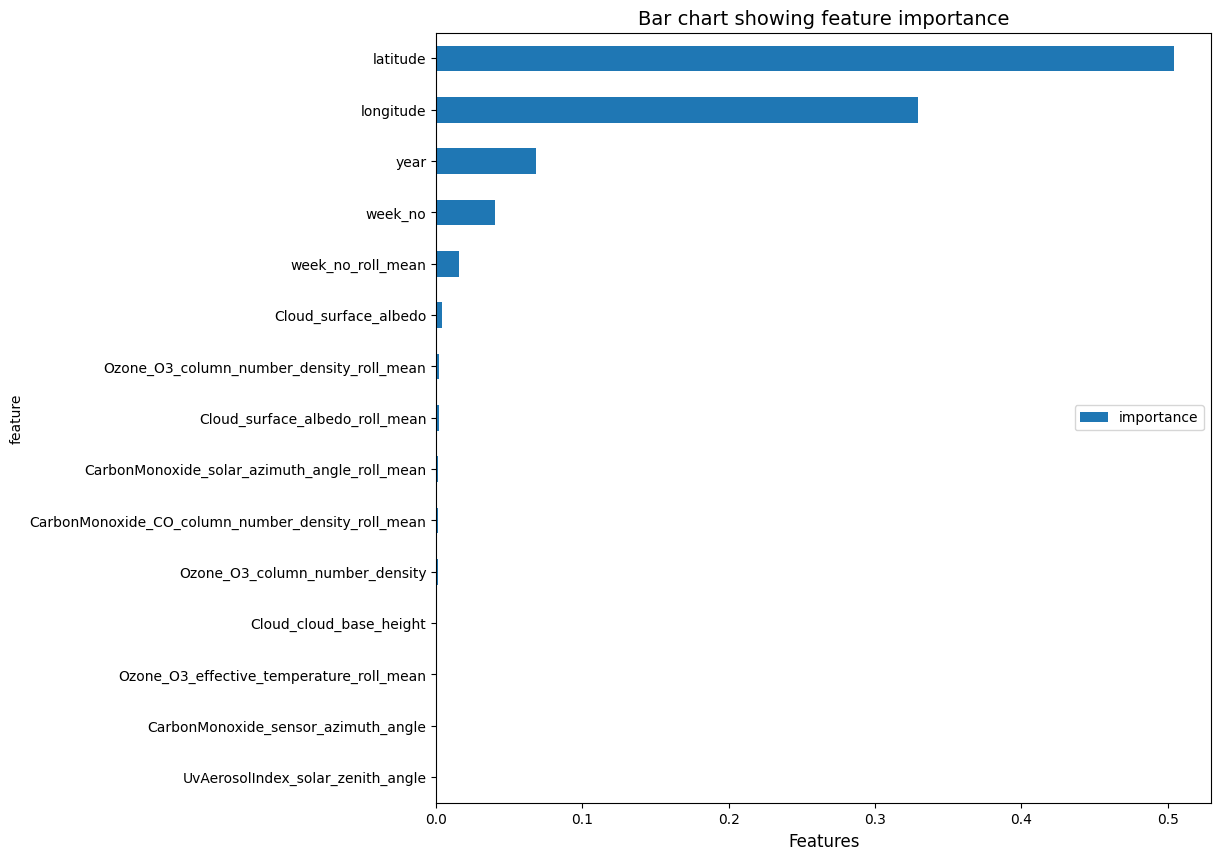

In [4]:
# 特徴量の重要度
impo_df = pd.DataFrame({'feature': X.columns, 'importance': clf.feature_importances_}).set_index('feature').sort_values(by='importance', ascending=False)
impo_df = impo_df[:15].sort_values(by='importance', ascending=True)
impo_df.plot(kind='barh', figsize=(10, 10))
plt.legend(loc='center right')
plt.title('Bar chart showing feature importance', fontsize=14)
plt.xlabel('Features', fontsize=12)
plt.show()

In [5]:
predictions = clf.predict(test.drop('ID_LAT_LON_YEAR_WEEK', axis=1))

In [6]:
sub_file = pd.DataFrame({'ID_LAT_LON_YEAR_WEEK': test.ID_LAT_LON_YEAR_WEEK, 'emission': predictions})
sub_file.head()

# Create file
sub_file.to_csv('submission.csv', index = False) # Download and submit, or submit via Notebook output